In [2]:
from PhyCRNet import PhyCRNet
from train_utils import load_checkpoint
import scipy.io as scio
import torch
import numpy as np

torch.Size([2, 400])
torch.Size([2, 201])


In [3]:
########### model inference ##################
time_batch_size_load = 300
time_steps =300
steps_load = time_batch_size_load
num_time_batch = int(time_steps / time_batch_size_load)
effective_step = list(range(0, steps_load))  

In [4]:
dt =0.5

In [5]:
model = PhyCRNet(
        input_channels = 1, 
  #     hidden_channels = [8, 32, 64, 64, 64, 32, 8], 
        hidden_channels = [16, 32, 64, 64, 64, 32, 16], 
        input_kernel_size = [4, 4, 4, 3, 3, 3, 3], 
        input_stride = [2, 2, 2, 1, 1, 1, 1], 
        input_padding = [1, 1, 1, 1, 1, 1, 1],  
        dt = dt,
        num_layers = [3, 1, 3, 3],
        upscale_factor = 8,
        step = time_steps, 
        effective_step = effective_step).cuda()

In [6]:
model_save_path = '/scratch/user/jungangc/PICNN/PhyCRNet-main-1phaseflow-final-paramBHP-64by64-200by05/Codes/model/checkpoint2000.pt'

In [7]:
data_dir = '/scratch/user/jungangc/PICNN/PhyCRNet-main-1phaseflow-final-paramBHP-64by64-200by05/Datasets/data/onephaseflow/pressure_401x1x64x64.mat'  
data = scio.loadmat(data_dir)
    # uv = data['uv'] # [t,c,h,w]  
uv = data['Psim'] # [t,c,h,w]  

    # initial conidtion
uv0 = uv[0:1,...] 
inputs = torch.tensor(uv0, dtype=torch.float32).cuda() 
print(inputs.size())


# set initial states for convlstm
num_convlstm = 1
#     (h0, c0) = (torch.randn(1, 128, 16, 16), torch.randn(1, 128, 16, 16))
(h0, c0) = (torch.zeros(1, 64, 8, 8), torch.zeros(1, 64, 8, 8))
initial_state = []
for i in range(num_convlstm):
    initial_state.append((h0, c0))

torch.Size([1, 1, 64, 64])


In [8]:
BHPmat = scio.loadmat('BHP_full.mat')
BHP_vec = torch.tensor(BHPmat['BHP_full'], dtype=torch.float32)

In [9]:
time_pred = np.arange(301)
# time_sim = np.arange(500)
time_sim = np.arange(301)

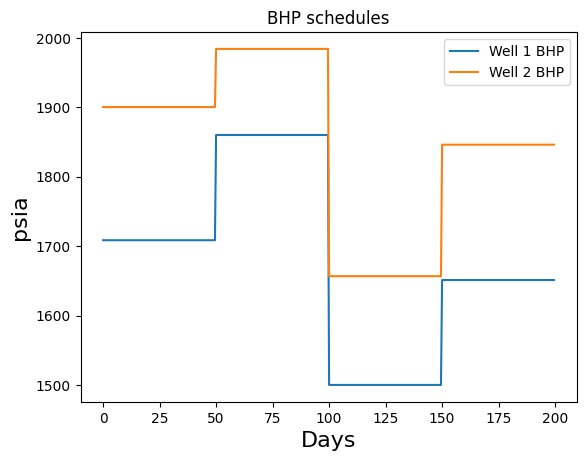

In [10]:
import matplotlib.pyplot as plt

# plt.plot(time_sim[1:]*dt, BHP_vec[0,:time_steps].numpy())
im = plt.plot(np.arange(400)*dt, BHP_vec[0,:].numpy(), label='Well 1 BHP')
plt.plot(np.arange(400)*dt, BHP_vec[1,:].numpy(), label='Well 2 BHP')
plt.legend()

# # change the label size
# im.figure.axes[0].tick_params(axis="both", labelsize=21)
plt.xlabel('Days', fontsize=16)
plt.ylabel('psia', fontsize=16)
plt.title('BHP schedules')
plt.show()

In [11]:
# source BHP 
BHP = np.zeros((time_steps,1,64,64))
source_BHP = torch.tensor(BHP, dtype=torch.float32).cuda()
source_BHP[:,0, 9, 9] = BHP_vec[0,:time_steps]
source_BHP[:,0, 54, 54] = BHP_vec[1,:time_steps]

In [12]:
model, _, _ = load_checkpoint(model, optimizer=None, scheduler=None, save_dir=model_save_path) 
output, last_state = model(initial_state, inputs, source_BHP)

Pretrained model loaded!


In [13]:
PressureList = [ x for x in output ]

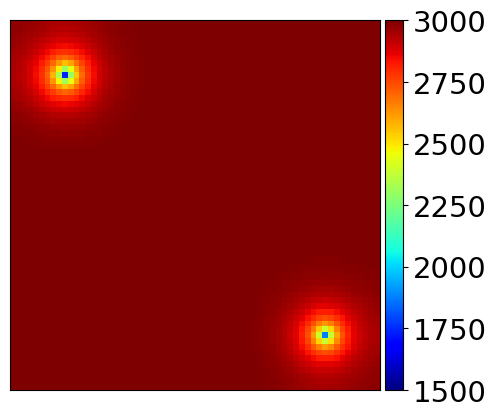

In [84]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
ax = plt.subplot()
im = ax.imshow((PressureList[200].cpu().detach().numpy().squeeze()), cmap='jet', vmin=1500, vmax=3000)

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


# # change the label size
# im.figure.axes[0].tick_params(axis="both", labelsize=21)
# remove x and y lables
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
# change the tick label size of colorbar
im.figure.axes[1].tick_params(axis="y", labelsize=21)
plt.show()

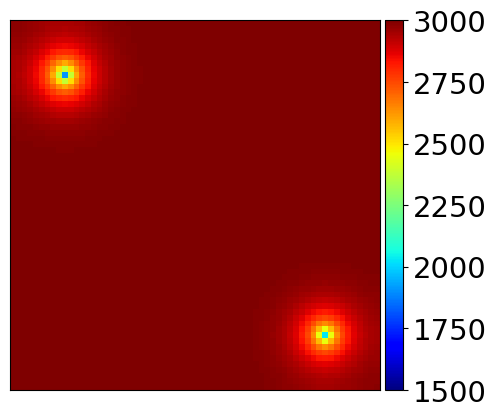

In [85]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = plt.subplot()
im = ax.imshow(uv[200].squeeze(), cmap='jet', vmin=1500, vmax=3000)

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

# # change the label size
# im.figure.axes[0].tick_params(axis="both", labelsize=21)
# remove x and y lables
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
# change the tick label size of colorbar
im.figure.axes[1].tick_params(axis="y", labelsize=21)

plt.show()

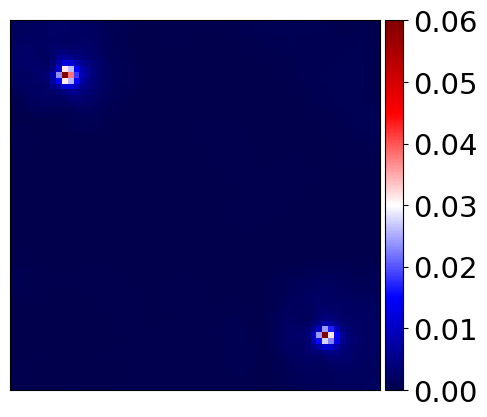

In [86]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = plt.subplot()
# im = ax.imshow((PressureList[100].detach().numpy()-uv[250]).squeeze(), cmap='seismic', vmin=-0.01, vmax=0.01)
im = ax.imshow((abs(PressureList[200].cpu().detach().numpy()-uv[200])/uv[200]).squeeze(), cmap='seismic',  vmin=0, vmax=0.06)

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

# # change the label size
# im.figure.axes[0].tick_params(axis="both", labelsize=21)
# remove x and y lables
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
# change the tick label size of colorbar
im.figure.axes[1].tick_params(axis="y", labelsize=21)
plt.show()

In [21]:
error_r=np.zeros(len(PressureList))
for i in range(len(PressureList)):
    # error_r[i] = np.mean(((PressureList[i].cpu().detach().numpy()-uv[i])/uv[i]).squeeze())
    error_r[i] = np.mean((abs(PressureList[i].cpu().detach().numpy()-uv[i])).squeeze())
    # error_r[i] = np.mean(((PressureList[i].cpu().detach().numpy()-uv[i])).squeeze())

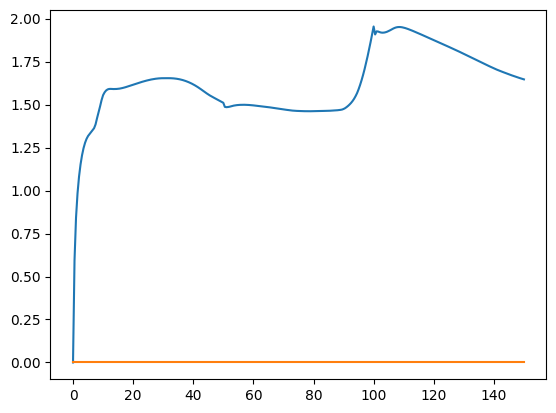

In [64]:
plt.plot(time_sim*dt, error_r)
plt.plot(time_sim*dt, np.zeros(len(error_r)))

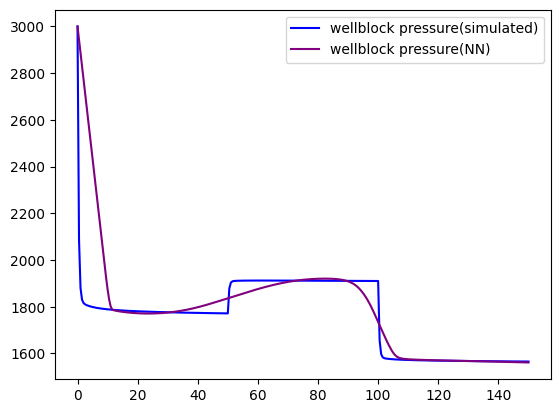

In [19]:
p_pred1 = np.zeros(time_steps+1)
p_sim1 = np.zeros(time_steps+1)
p_pred2 = np.zeros(time_steps+1)
p_sim2 = np.zeros(time_steps+1)
for k in range(time_steps+1):
    p_pred1[k] = PressureList[k][0:1, 0:1, 9,9]
    p_pred2[k] = PressureList[k][0:1, 0:1, 54,54]

for k in range(time_steps+1):
    p_sim1[k] = uv[k, 0:1, 9,9] 
    p_sim2[k] = uv[k, 0:1, 54,54] 
    
plt.plot(time_sim*dt, p_sim1, 'b')
plt.plot(time_pred*dt, p_pred1,'purple')
plt.legend(['wellblock pressure(simulated)', 'wellblock pressure(NN)'])

In [20]:
J_pro = 1.4033e3
fro =1.00

In [21]:
rate_pred1=np.zeros(time_steps+1)
rate_pred2=np.zeros(time_steps+1)
# rate_sim1=np.zeros(500)
# rate_sim2=np.zeros(500)
rate_sim1=np.zeros(time_steps+1)
rate_sim2=np.zeros(time_steps+1)

In [22]:
for k in range(time_steps+1):
    rate_pred1[k] = (PressureList[k][0:1, 0:1, 9,9]-BHP_vec[0,k])*J_pro*fro
    rate_pred2[k] = (PressureList[k][0:1, 0:1, 54,54]-BHP_vec[1,k])*J_pro*fro
    
    rate_sim1[k] = (uv[k, 0:1, 9,9]-BHP_vec[0,k].numpy())*J_pro*fro
    rate_sim2[k] = (uv[k, 0:1, 54,54]-BHP_vec[1,k].numpy())*J_pro*fro

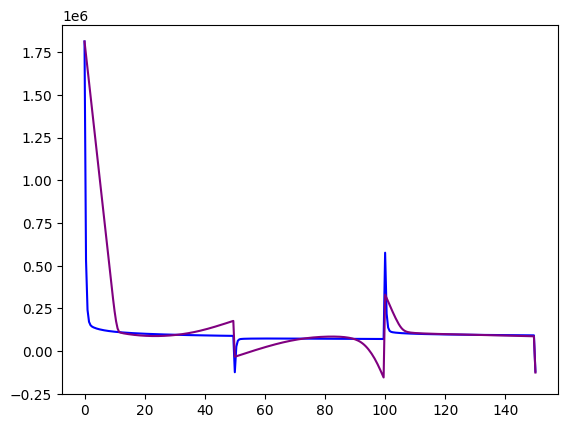

In [23]:
plt.plot(time_sim*dt, rate_sim1, 'blue')
plt.plot(time_pred*dt, rate_pred1,'purple')
# plt.ylim([0, 6.0e5])
plt.show()

In [14]:
### model inference
inputs_inf = output[time_steps]

In [15]:
# source BHP 
BHP = np.zeros((time_steps,1,64,64))
source_BHP_inf = torch.tensor(BHP, dtype=torch.float32).cuda()
source_BHP_inf[:,0, 9, 9] = BHP_vec[0,time_steps:].repeat(1,3)
source_BHP_inf[:,0, 54, 54] = BHP_vec[1,time_steps:].repeat(1,3)

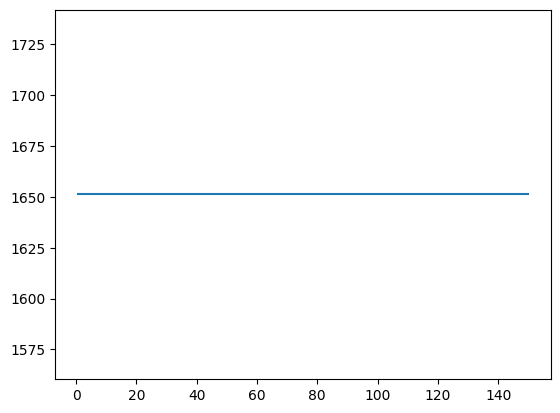

In [16]:
plt.plot(time_sim[1:]*dt, BHP_vec[0,time_steps:].repeat(1,3).numpy().squeeze())

In [17]:
model, _, _ = load_checkpoint(model, optimizer=None, scheduler=None, save_dir=model_save_path) 
output_inf, _ = model(last_state, inputs_inf, source_BHP_inf)

Pretrained model loaded!


In [18]:
PressureList_inf = [ x for x in output_inf ]

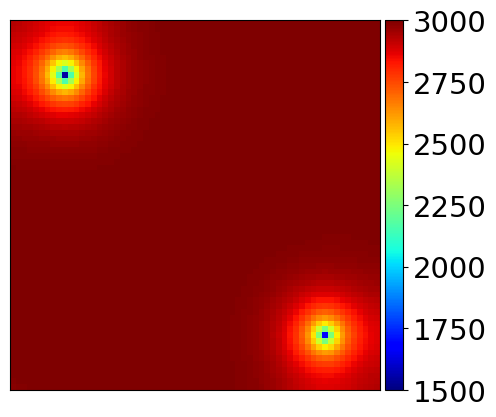

In [94]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = plt.subplot()
im = ax.imshow((PressureList_inf[60].cpu().detach().numpy().squeeze()), cmap='jet', vmin=1500, vmax=3000)

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

# # change the label size
# im.figure.axes[0].tick_params(axis="both", labelsize=21)
# remove x and y lables
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
# change the tick label size of colorbar
im.figure.axes[1].tick_params(axis="y", labelsize=21)
plt.show()

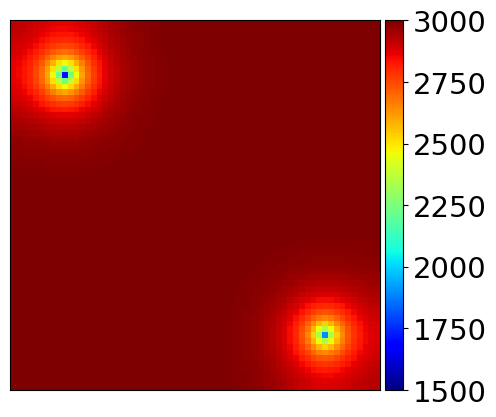

In [97]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = plt.subplot()
im = ax.imshow(uv[60+time_steps].squeeze(), cmap='jet', vmin=1500, vmax=3000)

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

# # change the label size
# im.figure.axes[0].tick_params(axis="both", labelsize=21)
# remove x and y lables
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
# change the tick label size of colorbar
im.figure.axes[1].tick_params(axis="y", labelsize=21)

plt.show()

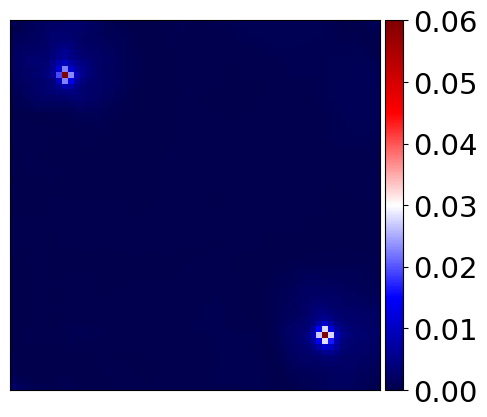

In [99]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = plt.subplot()
# im = ax.imshow((PressureList[100].detach().numpy()-uv[250]).squeeze(), cmap='seismic', vmin=-0.01, vmax=0.01)
im = ax.imshow((abs(PressureList_inf[20].cpu().detach().numpy()-uv[20+time_steps])/uv[20+time_steps]).squeeze(), cmap='seismic', vmin=0, vmax=0.06)

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

# # change the label size
# im.figure.axes[0].tick_params(axis="both", labelsize=21)
# remove x and y lables
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
# change the tick label size of colorbar
im.figure.axes[1].tick_params(axis="y", labelsize=21)

plt.show()

In [19]:
error_r_inf=np.zeros(len(BHP_vec[0,time_steps:]))
for i in range(len(BHP_vec[0,time_steps:])):
    # error_r[i] = np.mean(((PressureList[i].cpu().detach().numpy()-uv[i])/uv[i]).squeeze())
    error_r_inf[i] = np.mean((abs(PressureList_inf[i].cpu().detach().numpy()-uv[time_steps+i])).squeeze())

Text(0, 0.5, 'mean absolute error')

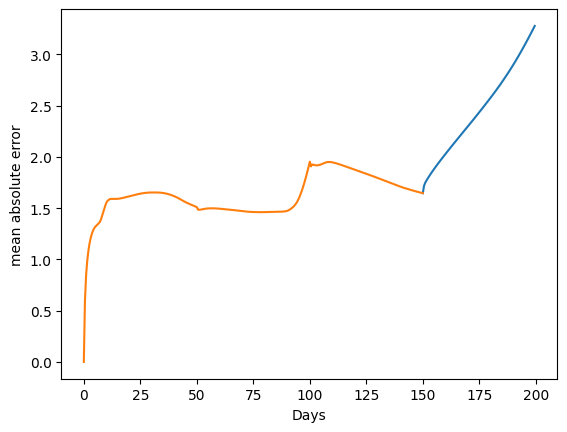

In [22]:
plt.plot((time_steps+np.arange(100))*dt, error_r_inf)
plt.plot(time_sim*dt, error_r)
plt.xlabel('Days')
plt.ylabel('mean absolute error')